# Volatility Modelling of Financial Assets

We will study two financial assets' time series, how they follow the stylized facts of financial time series and how we can model their volatility. We look at answering the following questions regarding the time series' behaviour and characteristics, which are related to the stylized facts of financial time series.

* Are the distributions of the empirical returns normal, and thus the asset's distributions log-normal?
* Does the empirical return distributions exhibit traits of leopokurtosis (fat tails)?
* Can we observe 'aggregated normality' between weekly returns and monthly returns?
* Are the returns heteroscedastic? 
* What are good models to describe the returns (and its volatility)?

In studying their stylized facts the following information will be examined.

* Price and return history
* Mean, standard deviation, skewness and excess kurtosis (with confidence)
* Bar-plots of returns
* QQ-plots of return distributions
* Volatility estimation and modelling

### Data Preparation

The assets in quetion are the S&P 500 and the AUD/USD currency pair from 2011-12-28 to 2021-12-28. Both weekly and monthly data will be fetch for each respective asset. Note, we are working with log-returns in this notebook, which are asceratined by the expression below. $$R_t = \textrm{ln}(\frac{S_t}{S_{t-1}}) \quad \forall t \in \{1,..,n \}$$

In [2]:
import numpy as np
from pandas_datareader import data as pdr

# Weekly data
spx_weekly = pdr.get_data_yahoo("^GSPC", start="2011-12-28", end="2021-12-28", interval="wk")
spx_weekly = spx_weekly["Adj Close"]
aud_weekly = pdr.get_data_yahoo("AUDUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
aud_weekly = aud_weekly["Adj Close"]

spx_weekly_returns = np.log(spx_weekly / spx_weekly.shift(1))
aud_weekly_returns = np.log(aud_weekly / aud_weekly.shift(1))

# Monthly data
spx_monthly = pdr.get_data_yahoo("^GSPC", start="2011-12-28", end="2021-12-28", interval="m")
spx_monthly = spx_monthly["Adj Close"]
aud_monthly = pdr.get_data_yahoo("AUDUSD=X", start="2011-12-28", end="2021-12-28", interval="m")
aud_monthly = aud_monthly["Adj Close"]

spx_monthly_returns = np.log(spx_monthly / spx_monthly.shift(1))
aud_monthly_returns = np.log(aud_monthly / aud_monthly.shift(1))

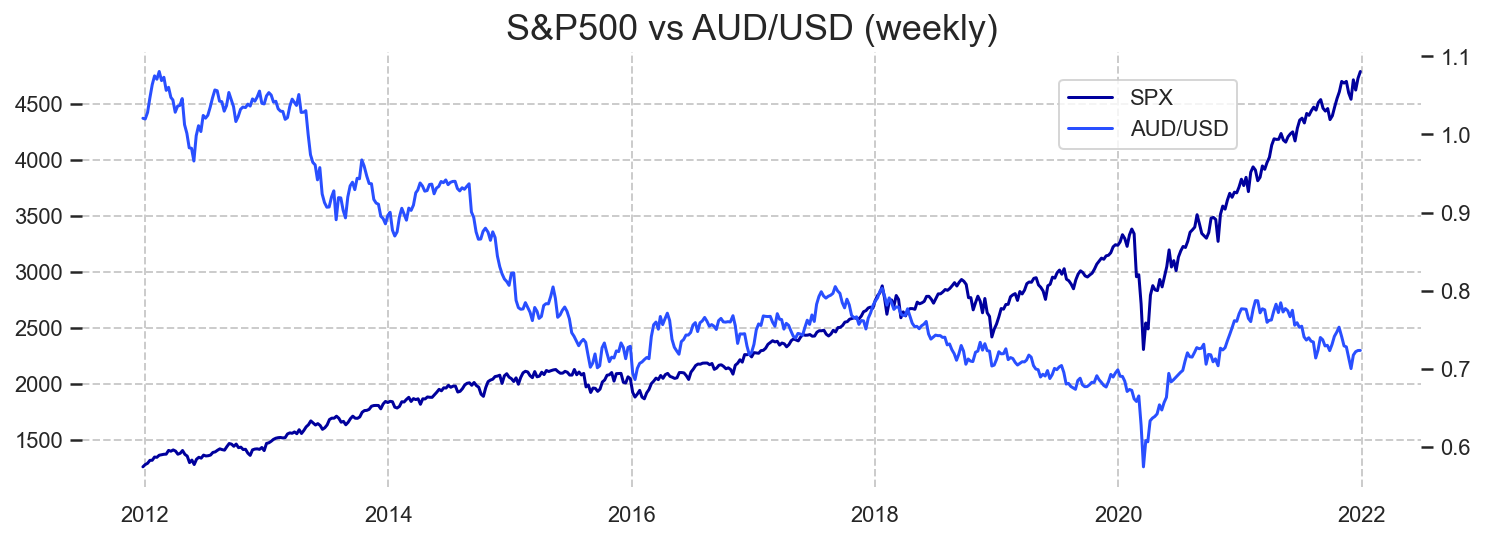

In [235]:
%config InlineBackend.figure_format = 'retina'


import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

ax1.set_frame_on(False)
ax2.set_frame_on(False)

ax1.plot(spx_weekly, label='SPX')
ax2.plot(aud_weekly, label='AUD/USD')

fig.set_size_inches(12, 4)
fig.legend(loc="upper right", bbox_to_anchor=(0.8,0.85))

plt.title('S&P500 vs AUD/USD (weekly)', fontsize=18)
plt.show()

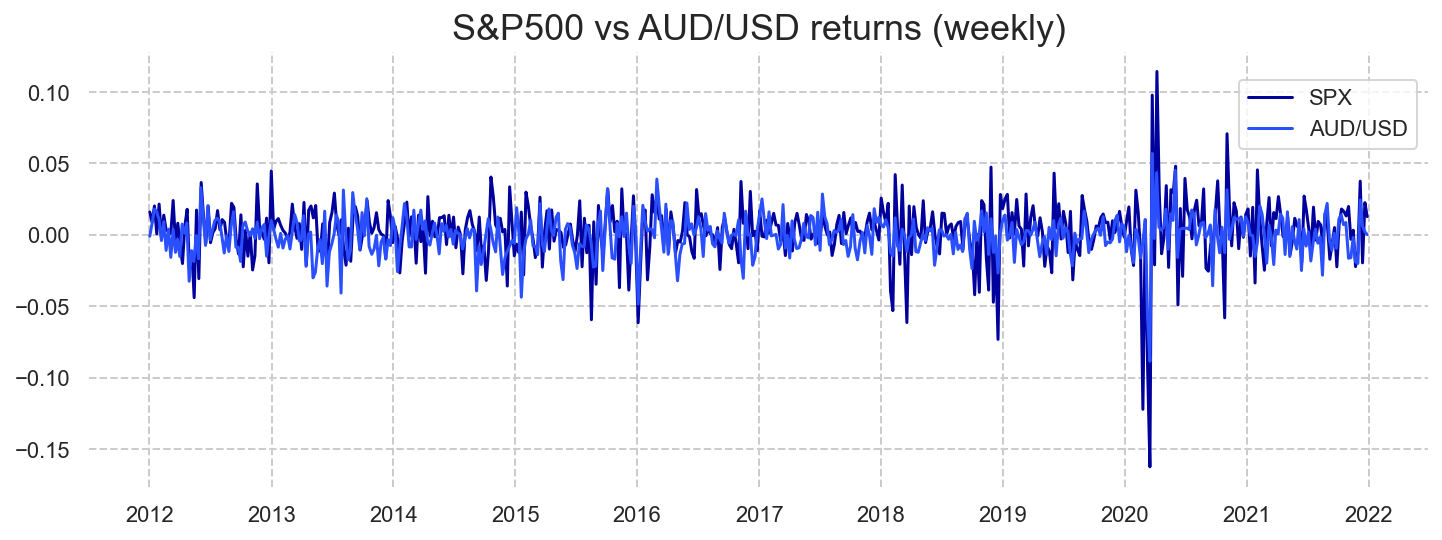

In [236]:
fig, ax = plt.subplots()
ax.plot(spx_weekly_returns, label='SPX')
ax.plot(aud_weekly_returns, label='AUD/USD')
ax.set_frame_on(False)

fig.set_size_inches(12, 4)
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.85))

plt.title('S&P500 vs AUD/USD returns (weekly)', fontsize=18)
plt.show()

### Descriptive Statistics

To examine the stylized facts of the time series we look at four statistical measures: mean, standard deviation, skew and (excess) kurtosis.

In [63]:
import pandas as pd

# Annualized mean returns
means = []
means.append(spx_weekly_returns.mean() * (52/1))
means.append(spx_monthly_returns.mean() * (12/1))
means.append(aud_weekly_returns.mean() * (52/1))
means.append(aud_monthly_returns.mean() * (12/1))

# Annualized sample standard deviations
stds = []
stds.append(spx_weekly_returns.std() * np.sqrt(52/1))
stds.append(spx_monthly_returns.std() * np.sqrt(12/1))
stds.append(aud_weekly_returns.std() * np.sqrt(52/1))
stds.append(aud_monthly_returns.std() * np.sqrt(12/1))

# Skewness 
skews = []
skews.append(spx_weekly_returns.skew())
skews.append(spx_monthly_returns.skew())
skews.append(aud_weekly_returns.skew())
skews.append(aud_monthly_returns.skew())

# Kurtosis
kurts = []
kurts.append(spx_weekly_returns.kurtosis())
kurts.append(spx_monthly_returns.kurtosis())
kurts.append(aud_weekly_returns.kurtosis())
kurts.append(aud_monthly_returns.kurtosis())

index = ['SPX weekly returns', 'SPX monthly returns', 'AUD/USD weekly returns', 'AUD/USD monthly returns']
columns = ['Annualized mean', 'Annualized std', 'Skewness', 'Kurtosis']

df_descriptive_statistics = pd.DataFrame(zip(means, stds, skews, kurts), index=index, columns=columns)
df_descriptive_statistics

,Annualized mean,Annualized std,Skewness,Kurtosis
SPX weekly returns,0.133144,0.153610,-1.280801,11.523748
SPX monthly returns,0.130052,0.130929,-0.697267,2.141690
AUD/USD weekly returns,-0.034306,0.098908,-0.600726,4.450244
AUD/USD monthly returns,-0.038174,0.103153,-0.002759,-0.215337


### Confidence Intervals

Given a sample $\{x_i\}_{i=1}^n$ which are iid (althoght independend is a sufficient condition), we can exploit the CLT to create a confidence interval for $ \hat{\mu} = \sum_i x_i$, since these will tend toward a normal distribution for $n \geq 30$. Given our $n$ observations we will end up with the two statistics below. Given that $\sigma$ is unknown we must estimate this, which changes the distribution from a normal to a Student's t-distribution. The expression for the confidence interval then follows easily.

$$ \frac{1}{n} (X_1 + \ldots + X_n) \xrightarrow{d} N(\mu, \frac{\sigma}{\sqrt{n}}) \implies$$

$$ \frac{\bar{X} - \mu}{\sigma / \sqrt{n}} \sim N(0, 1) \quad \textrm{and} \quad \frac{\bar{X} - \mu}{s / \sqrt{n}} \sim t(n-1)$$

$$ I_{\mu}^{1-\alpha} = \bar{x} \mp t_{\frac{\alpha}{2}}(n-1) \frac{s}{\sqrt{n}}$$

From statistical theory (Cochran's theorem) we have a test statistic of the sample standard deviation with a know distribution. Using this we can derive a confidence interval for the sample standard deviation which is also estimated in the statistics described previously. 

$$\frac{(n-1)S^2}{\sigma^2} \sim \chi^2(n-1)$$

$$ I_{\sigma}^{1-\alpha} = (\sqrt{\frac{(n-1)s^2}{\chi^2_{\frac{\alpha}{2}}(n-1)}}, \sqrt{\frac{(n-1)s^2}{\chi^2_{1 - \frac{\alpha}{2}}(n-1)}})  $$

Next we will calculate 95 per cent confidence intervals for the mean and standard devation of the weekly data of the SPX and AUD/USD currency pair. The confidence interval will be annualized.

In [70]:
from scipy import stats

# 95 % confidence interval of annualized returns & standard devations for the weekly spx data
quantiles_spx_weekly_mean = stats.t(df=len(spx_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_mean_spx_weekly = [spx_weekly_returns.mean() + quantiles_spx_weekly_mean[0] * spx_weekly_returns.std() / np.sqrt(len(spx_weekly_returns)),
                              spx_weekly_returns.mean() + quantiles_spx_weekly_mean[1] * spx_weekly_returns.std() / np.sqrt(len(spx_weekly_returns))]
confidence_mean_spx_weekly = [x * (52/1) for x in confidence_mean_spx_weekly]

quantiles_spx_weekly_std = stats.chi2(df=len(spx_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_std_spx_weekly = [np.sqrt((len(spx_weekly_returns)-1) * spx_weekly_returns.std() ** 2 / quantiles_spx_weekly_std[1]), 
                             np.sqrt((len(spx_weekly_returns)-1) * spx_weekly_returns.std() ** 2 / quantiles_spx_weekly_std[0])]
confidence_std_spx_weekly = [x * np.sqrt(52/1) for x in confidence_std_spx_weekly]

                
# 95 % confidence interval of annualized returns & standard devations for the weekly aud data
quantiles_aud_weekly_mean = stats.t(df=len(aud_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_mean_aud_weekly = [aud_weekly_returns.mean() + quantiles_aud_weekly_mean[0] * aud_weekly_returns.std() / np.sqrt(len(aud_weekly_returns)),
                              aud_weekly_returns.mean() + quantiles_aud_weekly_mean[1] * aud_weekly_returns.std() / np.sqrt(len(aud_weekly_returns))]
confidence_mean_aud_weekly = [x * (52/1) for x in confidence_mean_aud_weekly]

quantiles_aud_weekly_std = stats.chi2(df=len(aud_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_std_aud_weekly = [np.sqrt((len(aud_weekly_returns)-1) * aud_weekly_returns.std() ** 2 / quantiles_aud_weekly_std[1]), 
                             np.sqrt((len(aud_weekly_returns)-1) * aud_weekly_returns.std() ** 2 / quantiles_aud_weekly_std[0])]
confidence_std_aud_weekly = [x * np.sqrt(52/1) for x in confidence_std_aud_weekly]

confidence_intervals_mean = np.round([confidence_mean_spx_weekly, confidence_mean_aud_weekly], 3)
confidence_intervals_std = np.round([confidence_std_spx_weekly, confidence_std_aud_weekly], 3)

index = ['SPX weekly returns', 'AUD/USD weekly returns']
columns = ['95% confidence interval mean', '95% confidence interval std']
df_confidence_intervals = pd.DataFrame(zip(confidence_intervals_mean, confidence_intervals_std), index=index, columns=columns)
df_confidence_intervals


,95% confidence interval mean,95% confidence interval std
SPX weekly returns,"[0.038, 0.228]","[0.145, 0.164]"
AUD/USD weekly returns,"[-0.096, 0.027]","[0.093, 0.105]"


### Histogram 

By plotting the data as historgrams we can get a rough idea of which distribution the data follows. In normal financial data returns should be approximativley normally distributed, with data from larger time intervals tending more towards the normal distributions than those on small time scales. This is usually known as aggregated normality. 

In addition, using the calculated decriptive statistical measures before, we can also see if the empirical distributions exhibits traits of leptokurtosis (fat tails), which is common amount financial times series.

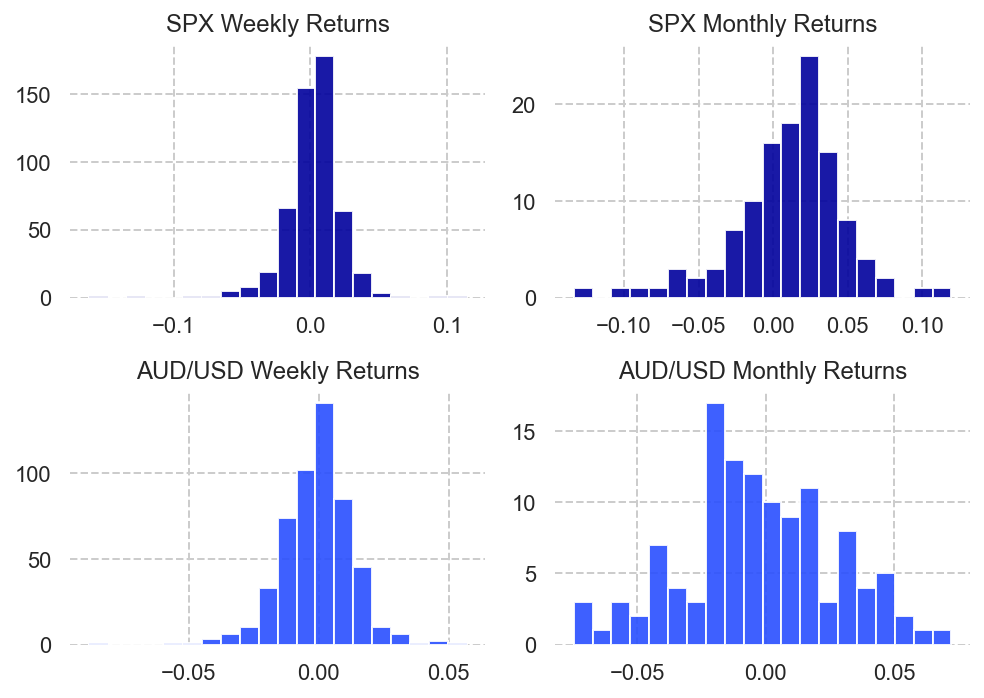

In [237]:
fig, axs = plt.subplots(2, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bins = 20
alpha = 0.9

axs[0, 0].hist(spx_weekly_returns, alpha=alpha, bins=bins)
axs[0, 0].set_title('SPX Weekly Returns')
axs[0, 0].set_frame_on(False)

axs[0, 1].hist(spx_monthly_returns, alpha=alpha, bins=bins)
axs[0, 1].set_title('SPX Monthly Returns')
axs[0, 1].set_frame_on(False)

axs[1, 0].hist(aud_weekly_returns, color=colors[1], alpha=alpha, bins=bins)
axs[1, 0].set_title('AUD/USD Weekly Returns')
axs[1, 0].set_frame_on(False)

axs[1, 1].hist(aud_monthly_returns, color=colors[1], alpha=alpha, bins=bins)
axs[1, 1].set_title('AUD/USD Monthly Returns')
axs[1, 1].set_frame_on(False)

fig.set_size_inches(7, 5)
plt.tight_layout()
plt.show()

### QQ - Plots

With the help of quantile-quantile (qq) plots we can identify whether two distributions are equal by visual inspection. A qq plots is based on the idea that two identical distributions should have the same quantiles (ignoring a constant scaling factor). Therefore, scatter plotting the quantiles of the two distributions should yield a straight line. In our case, we test whether the returns for each time series is normally distributed. 

This is done by noting that the quantiles of the empirical distribution is the same as the observations themselves, if we look at the $i/n\ \forall i \in \{1,...,n \}$ quantiles. Secondly, we find the same number of quantiles in the normal distribution to match against and plot. However, we do not look at $\Phi^{-1}(\frac{i}{n})$ since this approaches infinity when $i=n$. Instead we compute $\Phi^{-1}(\frac{i - 0.5}{n})$.

Also, a so-called qq line is added to more easily if the distribtuions fit. This is done by looking at the 25th and 75th percentile point in each distribution, and plotting the apporpriate $y=mx+b$ line.

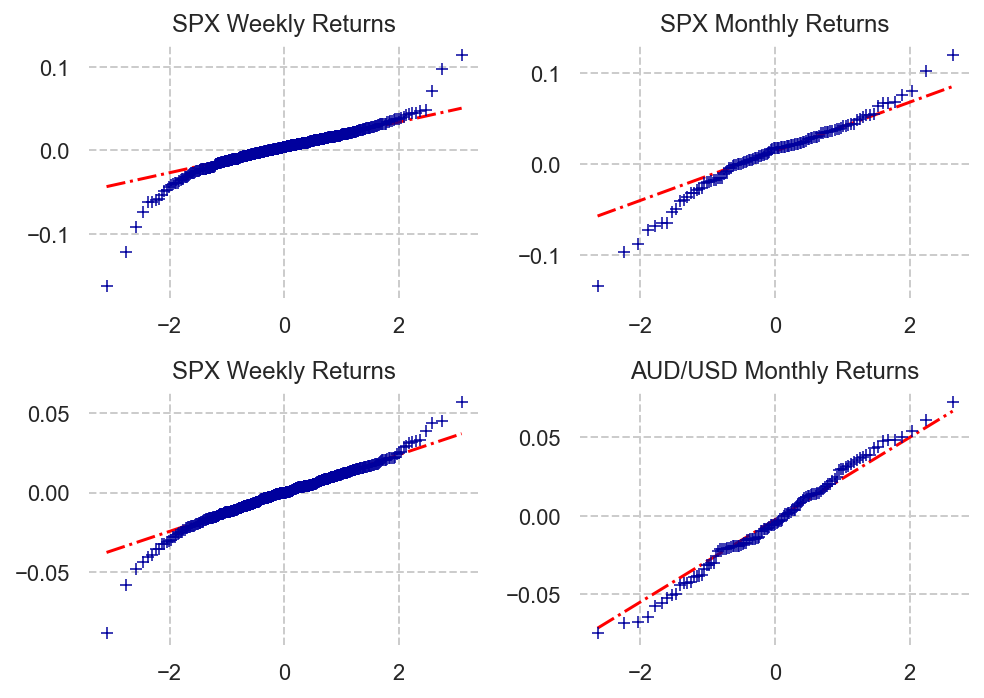

In [238]:
def qq_plot_normal(observations):
    observations.sort()
    n_observations = len(observations)

    empirical_quantiles = observations
    theoretical_quantiles = [stats.norm.ppf((i - 0.5)/n_observations) for i in range(1, n_observations + 1)]

    ## qq-line (y = mx + b) based on the 25th and 75th quantile of each distribtuion. 
    (x1, x2) = stats.norm.ppf((0.25, 0.75))
    (y1, y2) = np.quantile(observations, (0.25, 0.75))

    slope = (y2 - y1)/(x2 - x1)
    intercept = y2 - (slope * x2)
    qqrange = np.linspace(theoretical_quantiles[0], theoretical_quantiles[-1])
    qqline = [slope * x + intercept for x in qqrange]

    #ax.plot(qqrange, qqline, linestyle='dashdot', color='red')
    #ax.scatter(theoretical_quantiles, empirical_quantiles, marker='+', linewidths=0.75, zorder=2)
    return ([theoretical_quantiles, empirical_quantiles], [qqrange, qqline])


fig, axs = plt.subplots(2, 2)

marker = '+'
linewidths=0.75
zorder = 2
qq_color = 'red'
linestyle = 'dashdot'


qq_spx_weekly = qq_plot_normal(spx_weekly_returns[1:].to_list())
axs[0, 0].plot(qq_spx_weekly[1][0], qq_spx_weekly[1][1], color=qq_color, linestyle=linestyle)
axs[0, 0].scatter(qq_spx_weekly[0][0], qq_spx_weekly[0][1], marker=marker, linewidths=linewidths, zorder=zorder)
axs[0, 0].set_title('SPX Weekly Returns')
axs[0, 0].set_frame_on(False)

qq_spx_monthly = qq_plot_normal(spx_monthly_returns[1:].to_list())
axs[0, 1].plot(qq_spx_monthly[1][0], qq_spx_monthly[1][1], color=qq_color, linestyle=linestyle)
axs[0, 1].scatter(qq_spx_monthly[0][0], qq_spx_monthly[0][1], marker=marker, linewidths=linewidths, zorder=zorder)
axs[0, 1].set_title('SPX Monthly Returns')
axs[0, 1].set_frame_on(False)

qq_aud_weekly = qq_plot_normal(aud_weekly_returns[1:].to_list())
axs[1, 0].plot(qq_aud_weekly[1][0], qq_aud_weekly[1][1], color=qq_color, linestyle=linestyle)
axs[1, 0].scatter(qq_aud_weekly[0][0], qq_aud_weekly[0][1], marker=marker, linewidths=linewidths, zorder=zorder)
axs[1, 0].set_title('SPX Weekly Returns')
axs[1, 0].set_frame_on(False)

qq_aud_monthly = qq_plot_normal(aud_monthly_returns[1:].to_list())
axs[1, 1].plot(qq_aud_monthly[1][0], qq_aud_monthly[1][1], color=qq_color, linestyle=linestyle)
axs[1, 1].scatter(qq_aud_monthly[0][0], qq_aud_monthly[0][1], marker=marker, linewidths=linewidths, zorder=zorder)
axs[1, 1].set_title('AUD/USD Monthly Returns')
axs[1, 1].set_frame_on(False)


fig.set_size_inches(7, 5)
plt.tight_layout()
plt.show()

### Volatility Estimation and Modelling



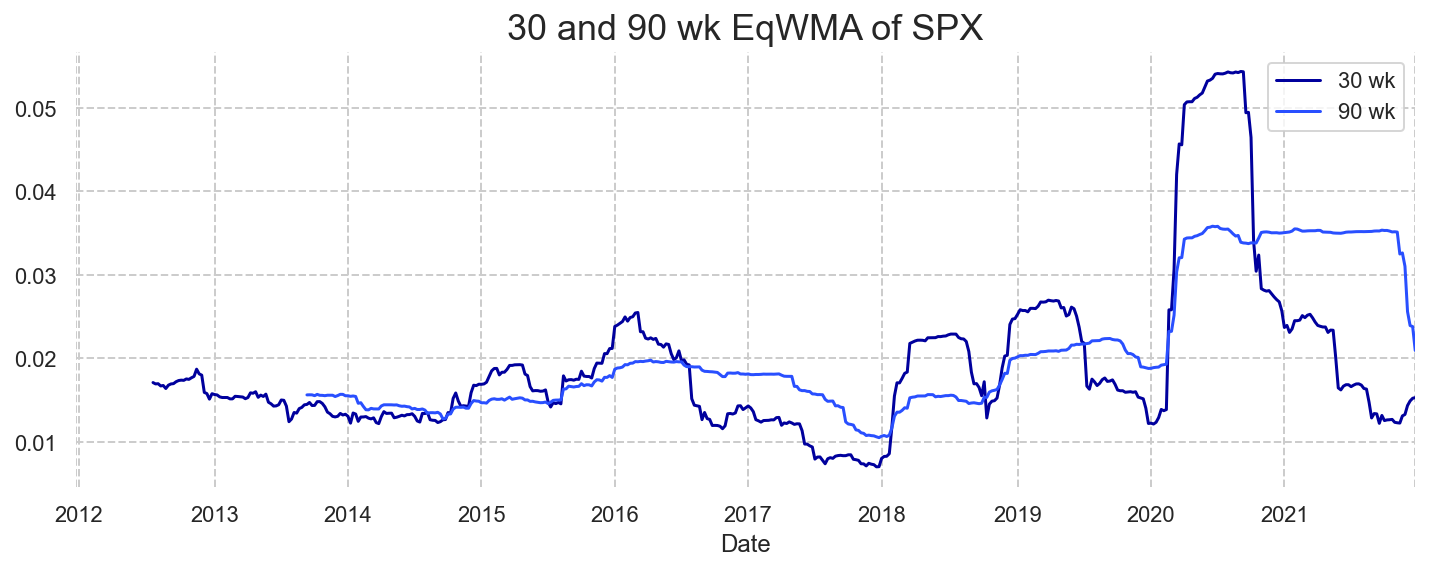

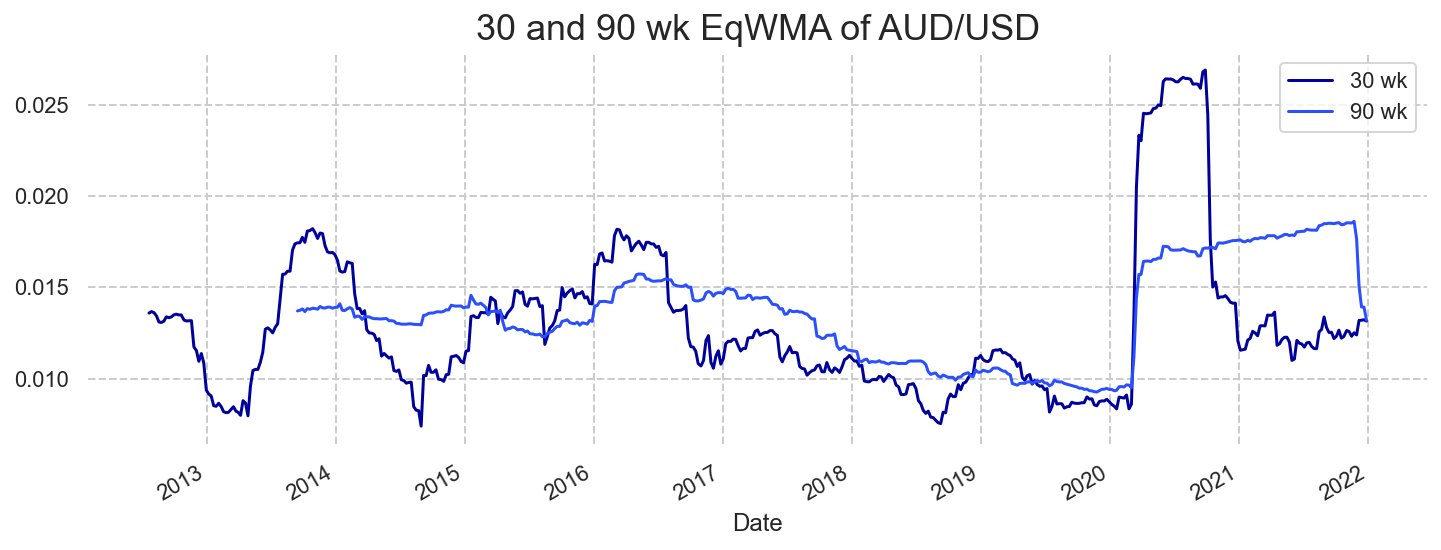

In [273]:
def EqWMA(data):
    return data.std(ddof=0)

fig, ax = plt.subplots()
spx_weekly_returns.rolling(30).apply(EqWMA).plot(label='30 wk')
spx_weekly_returns.rolling(90).apply(EqWMA).plot(label='90 wk')
fig.set_size_inches(12, 4)
plt.box(False)
plt.title('30 and 90 wk EqWMA of SPX', fontsize=18)
plt.legend()
plt.show()

fig, ax = plt.subplots()
aud_weekly_returns.rolling(30).apply(EqWMA).plot(label='30 wk')
aud_weekly_returns.rolling(90).apply(EqWMA).plot(label='90 wk')
fig.set_size_inches(12, 4)
plt.box(False)
plt.title('30 and 90 wk EqWMA of AUD/USD', fontsize=18)
plt.legend()
plt.show()

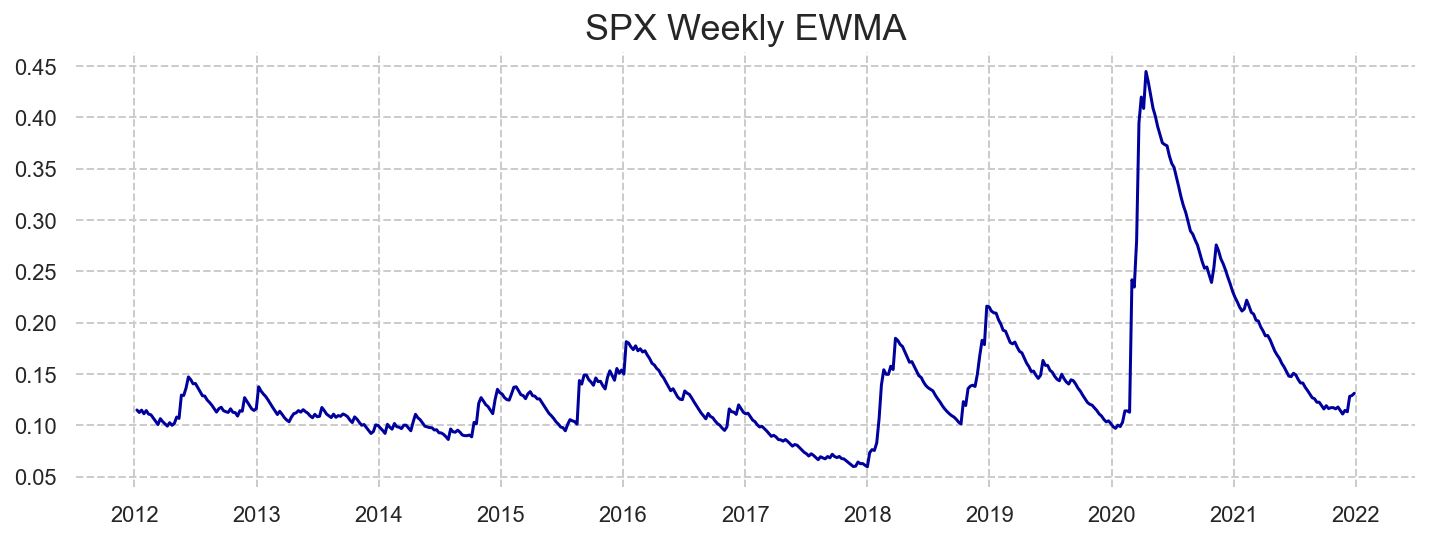

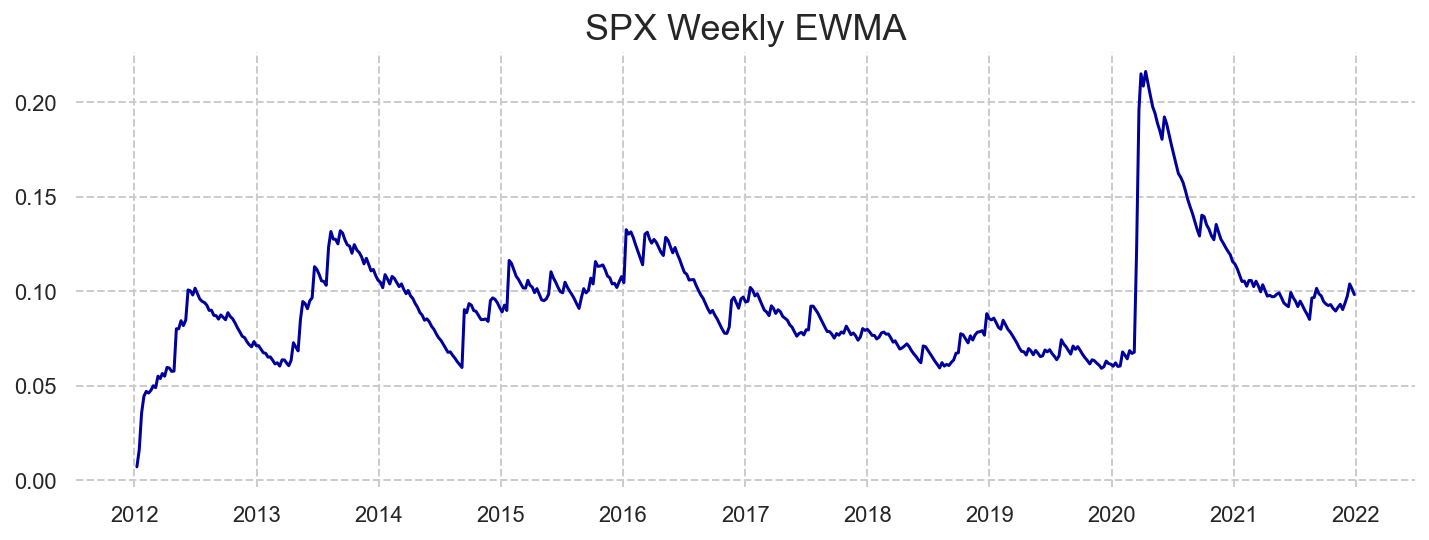

In [367]:
def GARCH_annualized(data, omega, alpha, beta, measurement_time, title):
    n_observations = len(data)
    vol_est = np.sqrt(omega + alpha * (data[0] ** 2) + beta * (data[0] ** 2))
    vol = []
    for i in range(1, n_observations):
        vol.append(vol_est)
        vol_est = np.sqrt(omega + alpha * (data[i] ** 2) + beta * (vol_est ** 2))
    vol_annual = [x * np.sqrt(1/measurement_time) for x in vol]

    time = data[1:].index
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    plt.plot(time, vol_annual)
    plt.title(title, fontsize=18)
    plt.box(False)

def EWMA_annualized(data, lamb, measurement_time, title):
    return GARCH_annualized(data, 0, (1-lamb), lamb, measurement_time, title)

EWMA_annualized(spx_weekly_returns[1:], 0.94, 1/52, 'SPX Weekly EWMA')
EWMA_annualized(aud_weekly_returns[1:], 0.94, 1/52, 'SPX Weekly EWMA')

In order to work with the GARCH(1, 1) model and a more realistic EWMA model we must Maximum Likelihood Estimate the parameters of these processes. This is done by noting that each return in our model is conditionally normal.

In [306]:
def log_likelihood(param, data):
    # param[0] will be omega
    # param[1] will be alpha
    # param[2] will be beta

    log_likelihood = 0
    vol_est = param[0] + param[1] * (data[1] ** 2) + param[2] * (data[1] ** 2)
    n_observations = len(data)

    for i in range(2, n_observations):
        log_likelihood = log_likelihood + (np.log(vol_est) + (data[i] ** 2) / vol_est)
        vol_est = param[0] + param[1] * (data[i] ** 2) + param[2] * vol_est
        
    return log_likelihood

In [348]:
from scipy.optimize import minimize

cons_ewma = [{'type': 'eq', 'fun': lambda x: x[0]},
             {'type': 'eq', 'fun': lambda x: x[1] + x[2] - 1},
             {'type': 'ineq', 'fun': lambda x: x[1]},
             {'type': 'ineq', 'fun': lambda x: x[2]}]

cons_garch = [{'type': 'ineq', 'fun': lambda x:  -x[1] - x[2] + 1},
        {'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]}]

cons_garch_VT = 0

x0 = [0, 0.06, 0.94]
result_spx_ewma = minimize(log_likelihood, x0, constraints = cons_ewma, args=spx_weekly_returns)

x0 = [0, 0.05, 0.95]
result_aud_ewma = minimize(log_likelihood, x0, constraints=cons_ewma, args=aud_weekly_returns)

x0 = [0.022, 0.3, 0.2]       
result_spx_garch = minimize(log_likelihood, x0, constraints = cons_garch, args=spx_weekly_returns)

x0 = [0.1, 0.3, 0.4]
result_aud_garch = minimize(log_likelihood, x0, constraints = cons_garch, args=aud_weekly_returns)

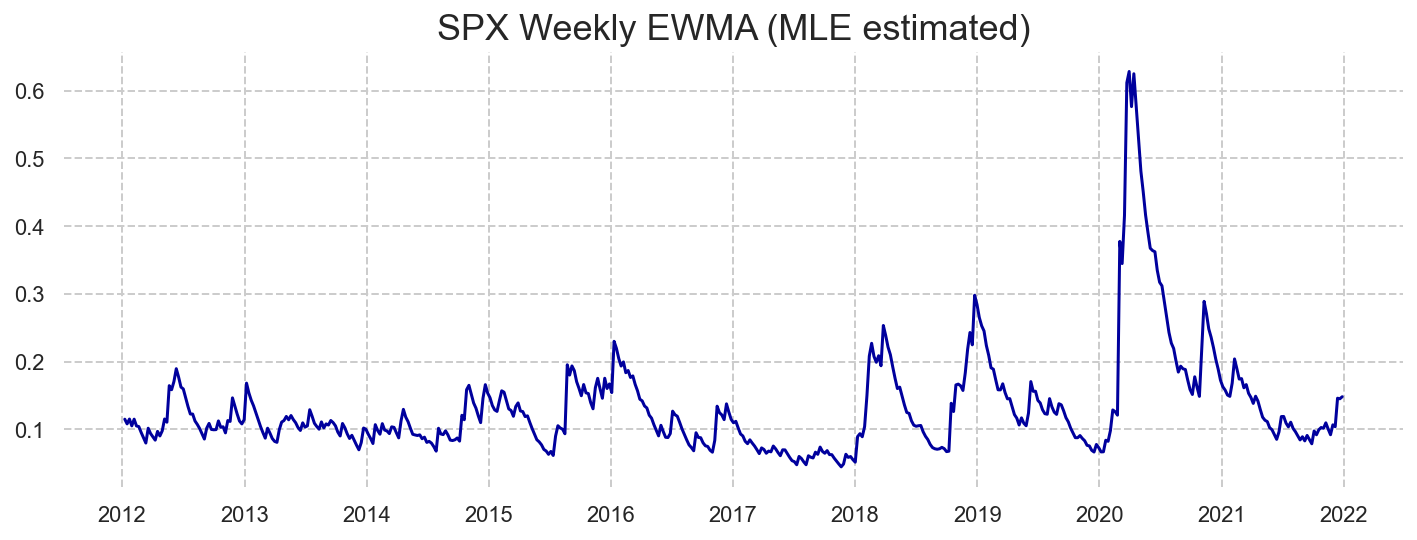

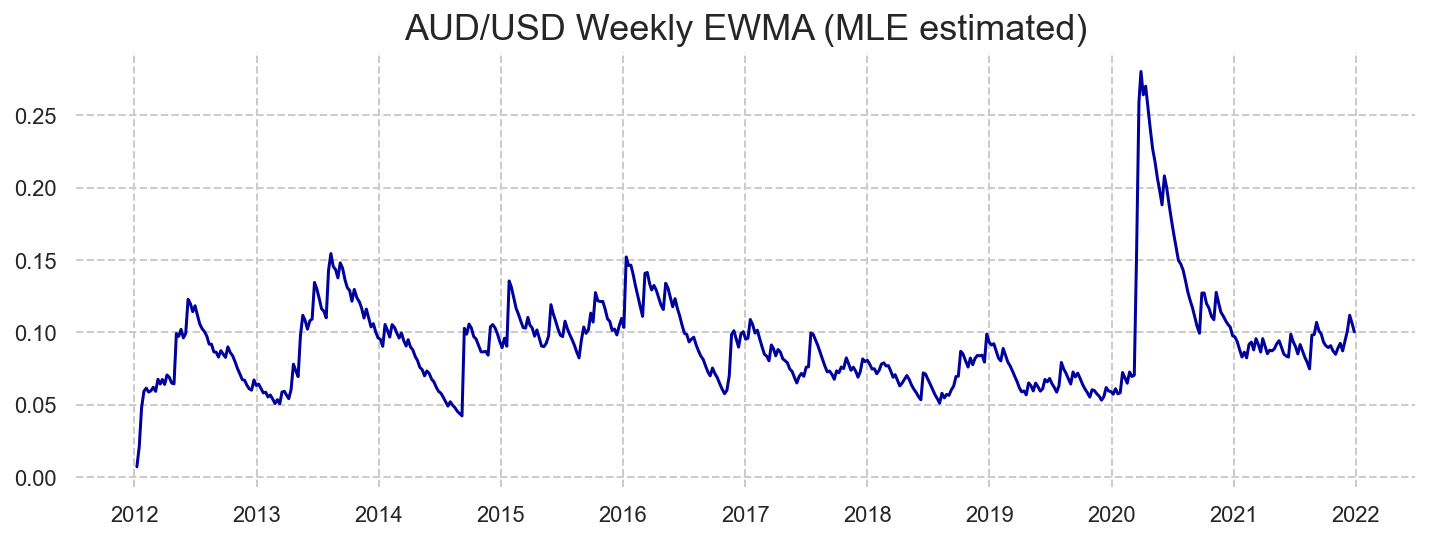

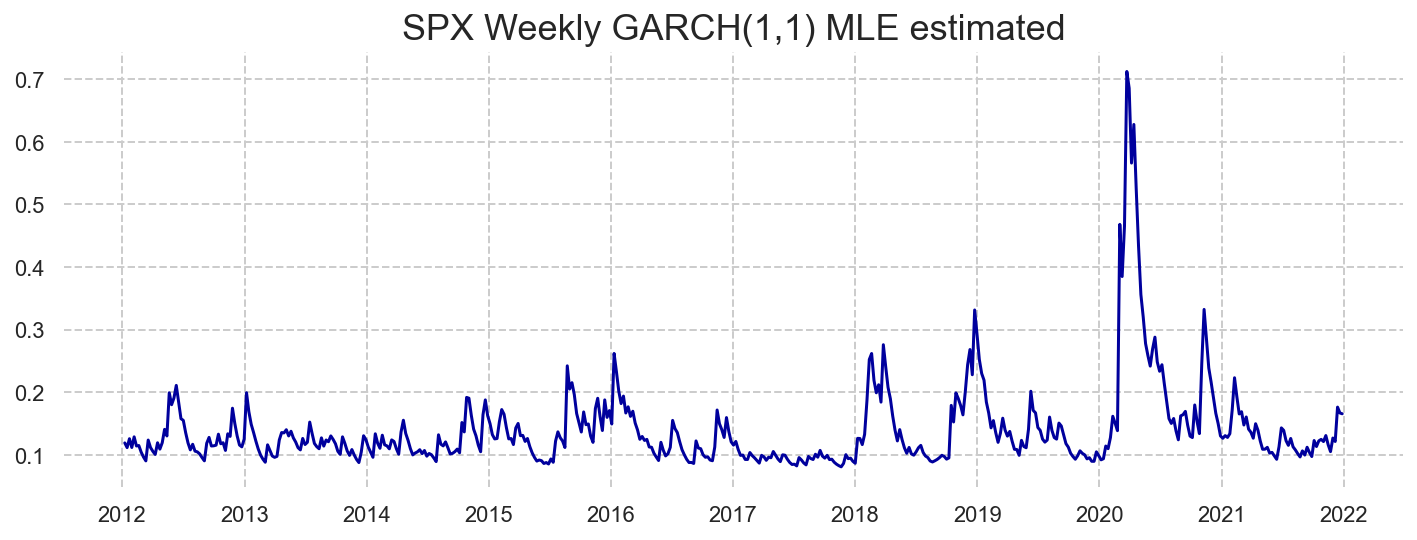

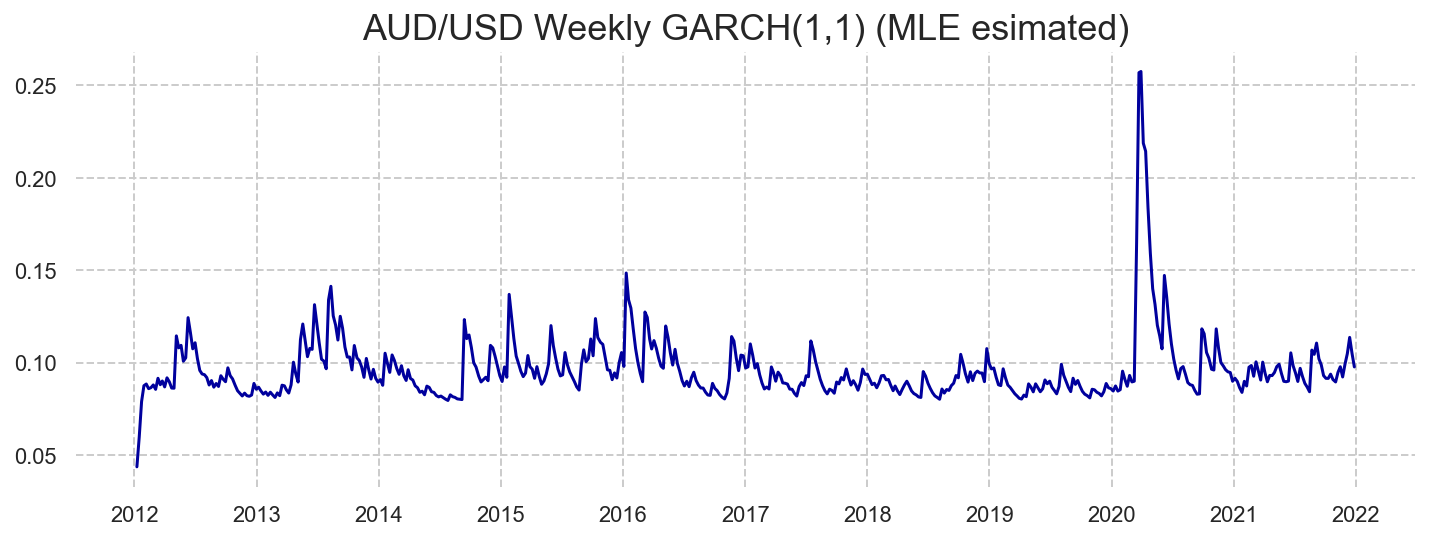

In [368]:
EWMA_annualized(spx_weekly_returns[1:], result_spx_ewma.x[2], 1/52, 'SPX Weekly EWMA (MLE estimated)')
EWMA_annualized(aud_weekly_returns[1:], result_aud_ewma.x[2], 1/52, 'AUD/USD Weekly EWMA (MLE estimated)')
GARCH_annualized(spx_weekly_returns[1:], result_spx_garch.x[0], result_spx_garch.x[1], result_spx_garch.x[2], 1/52, 'SPX Weekly GARCH(1,1) MLE estimated')
GARCH_annualized(aud_weekly_returns[1:], result_aud_garch.x[0], result_aud_garch.x[1], result_aud_garch.x[2], 1/52, 'AUD/USD Weekly GARCH(1,1) (MLE esimated)')

### Volatility Forecast and Monte Carlo Simulation